## Model Training to test

---


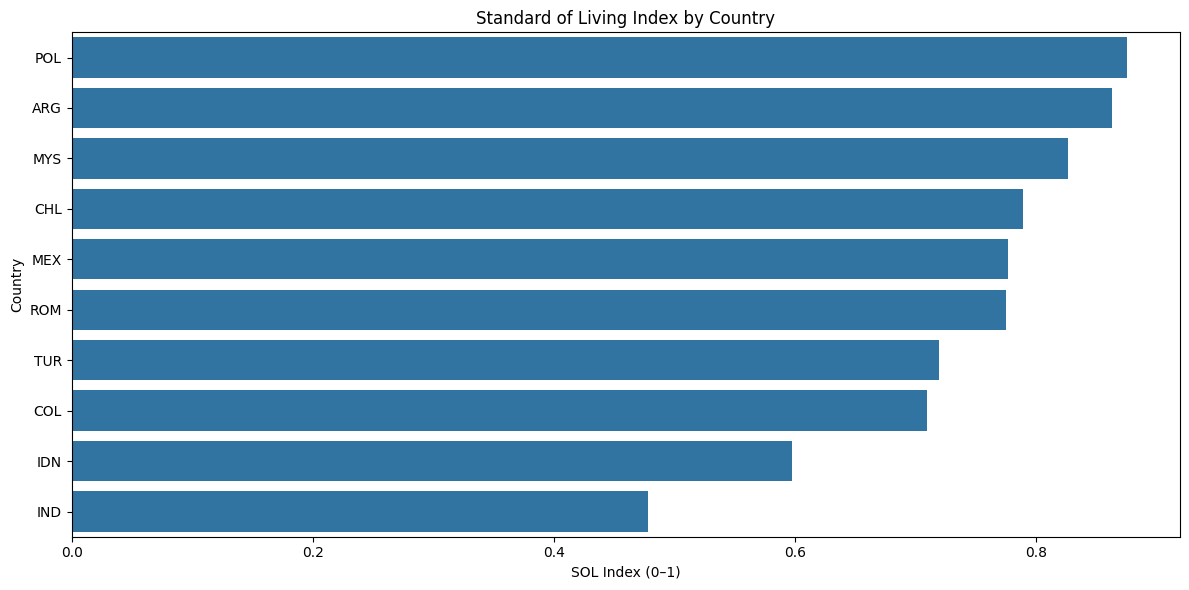

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ LOAD DATA
# -----------------------------
df = pd.read_excel("check.xlsx")  # Replace with your file

# Detect country column
possible_country_cols = [c for c in df.columns if str(c).lower().startswith('country')]
if not possible_country_cols:
    raise KeyError("No country column starting with 'Country' found.")
country_col = possible_country_cols[0]

# Columns used for SOL (NO 'Improved water')
cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    # Urban handled below (either % or derived from counts)
    'Access to improved sanitation (% of total pop.)': 'sanitation',
    # 'Access to improved water source (% of total pop.)'  <-- intentionally removed
}

# Ensure required columns exist (excluding urban which is handled separately)
missing = [c for c in cols.keys() if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for SOL calculation: {missing}")

# Urban: prefer % if exists, else derive from counts
urban_pct_col = 'Urban population (%)'
if urban_pct_col in df.columns:
    df['_urban_pct'] = df[urban_pct_col].astype(float)
else:
    if 'Urban population' not in df.columns or 'Population' not in df.columns:
        raise KeyError("Need either 'Urban population (%)' or both 'Urban population' and 'Population' to compute urban share.")
    # Avoid divide-by-zero
    df['_urban_pct'] = (df['Urban population'].astype(float) /
                        df['Population'].replace(0, np.nan).astype(float)) * 100.0

# -----------------------------
# 2️⃣ COUNTRY-LEVEL MEANS
# -----------------------------
group_cols = list(cols.keys()) + ['_urban_pct']
country_means = df.groupby(country_col)[group_cols].mean(numeric_only=True).reset_index()
country_means = country_means.rename(columns=cols)
country_means = country_means.rename(columns={'_urban_pct': 'urban_pct'})

# Normalisation denominators
mort_max = country_means['under5'].replace(0, np.nan).max()
phys_max = country_means['physicians'].replace(0, np.nan).max()
mort_max = mort_max if pd.notna(mort_max) else 1.0
phys_max = phys_max if pd.notna(phys_max) else 1.0

# -----------------------------
# 3️⃣ SOL COMPONENTS (0–1)
# -----------------------------
country_means['E_primary']  = country_means['primary'] / 100.0
country_means['H_under5']   = 1.0 - (country_means['under5'] / mort_max)
country_means['P_phys']     = country_means['physicians'] / phys_max
country_means['I_gni']      = country_means['gni'] / 100.0
country_means['Pov_not']    = 1.0 - (country_means['poverty'] / 100.0)
country_means['R_roads']    = country_means['paved_roads'] / 100.0
country_means['U_urban']    = country_means['urban_pct'] / 100.0
country_means['S_san']      = country_means['sanitation'] / 100.0

comp_cols = ['E_primary','H_under5','P_phys','I_gni','Pov_not','R_roads','U_urban','S_san']
country_means[comp_cols] = country_means[comp_cols].clip(0.0, 1.0)

# -----------------------------
# 4️⃣ WEIGHTS & INDEX (water removed)
# -----------------------------
weights = {
    'E_primary': 0.15,
    'H_under5':  0.15,
    'P_phys':    0.10,
    'I_gni':     0.15,
    'Pov_not':   0.10,
    'R_roads':   0.10,
    'U_urban':   0.05,
    'S_san':     0.10,
}
# Re-normalise to sum to 1.0 (since 'water' was removed)
w_sum = sum(weights.values())
norm_weights = {k: v / w_sum for k, v in weights.items()}

country_means['SOL_index'] = sum(country_means[c] * w for c, w in norm_weights.items())

# -----------------------------
# 5️⃣ QUICK VISUALS
# -----------------------------
# Sort countries by SOL
country_means_sorted = country_means.sort_values('SOL_index', ascending=False)

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='SOL_index', y=country_col, data=country_means_sorted)
plt.title("Standard of Living Index by Country")
plt.xlabel("SOL Index (0–1)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("check_with_sli.xlsx")

# Drop missing or irrelevant columns
df = df.dropna(subset=["SOL_index"])
X = df.select_dtypes(include=["number"]).drop(columns=["SOL_index"])
y = df["SOL_index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

R²: -6.4697651137516825
MAE: 0.01900519163436587


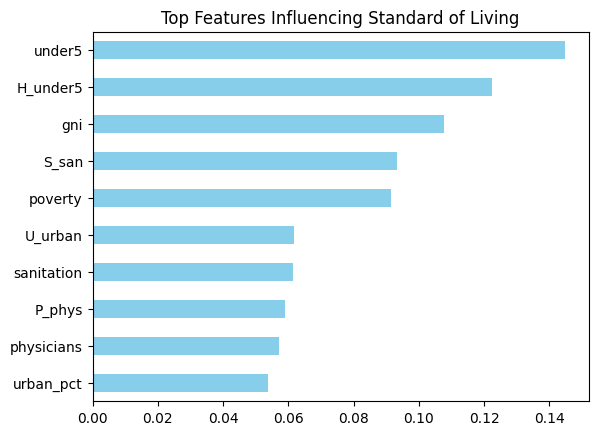

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top Features Influencing Standard of Living")
plt.show()

Decision Tree — R²: -11.791451519595144
Decision Tree — MAE: 0.019145721367291146


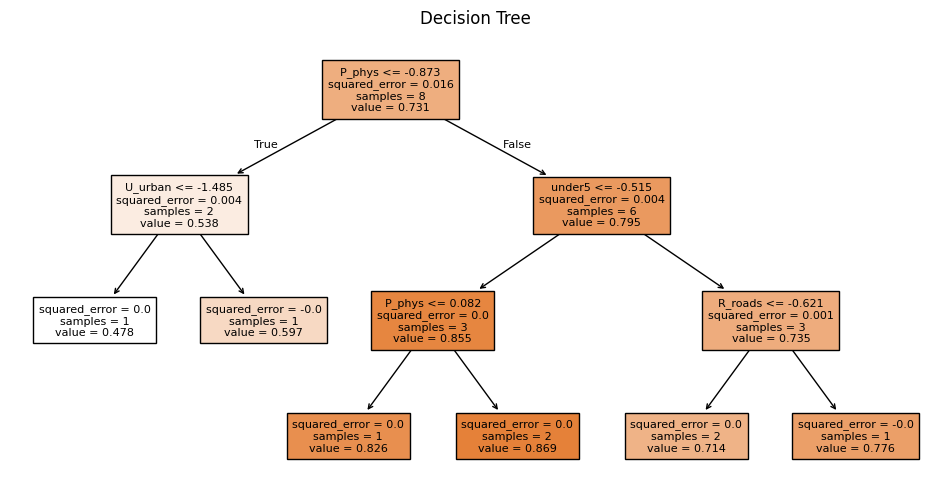

In [65]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("Decision Tree — R²:", r2_score(y_test, y_pred_dt))
print("Decision Tree — MAE:", mean_absolute_error(y_test, y_pred_dt))

# Plot (first 3 levels only for readability)
plt.figure(figsize=(12, 6))
plot_tree(dt, max_depth=3, feature_names=X.columns, filled=True, fontsize=8)
plt.title("Decision Tree")
plt.show()


In [66]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

print("Gradient Boosting — R²:", r2_score(y_test, y_pred_gbr))
print("Gradient Boosting — MAE:", mean_absolute_error(y_test, y_pred_gbr))

Gradient Boosting — R²: -19.336773902219047
Gradient Boosting — MAE: 0.03163023827620265


In [67]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression — R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression — MAE:", mean_absolute_error(y_test, y_pred_lr))

Linear Regression — R²: 0.9898720911782295
Linear Regression — MAE: 0.0006858685216373228


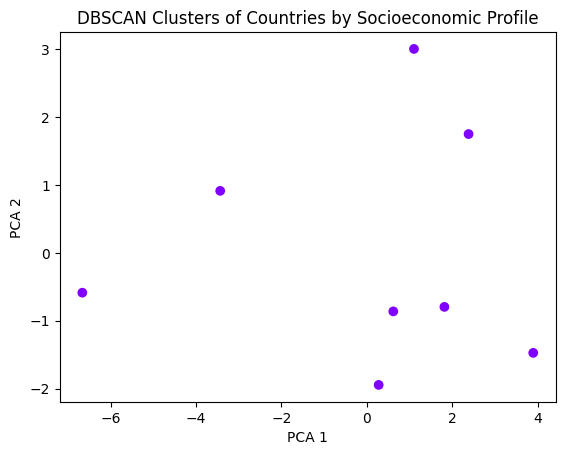

In [68]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

db = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=db.labels_, cmap='rainbow')
plt.title("DBSCAN Clusters of Countries by Socioeconomic Profile")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [69]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# Detect the country column automatically
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
if not country_col:
    raise KeyError("No column starting with 'Country' found. Check df.columns output.")

# Select numeric columns only (drop SOL_index to avoid target leakage)
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')

# Standardise numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)

# Label outliers
outliers = df[df['anomaly'] == -1]

print("⚠️ Countries performing unexpectedly (outliers):")
print(outliers[[country_col, 'SOL_index']].head(10))


⚠️ Countries performing unexpectedly (outliers):
  Country code  SOL_index
4          IND   0.478028


               Model         R²       MAE
3  Linear Regression   0.989872  0.000686
1      Random Forest  -6.469765  0.019005
0      Decision Tree -11.791452  0.019146
2  Gradient Boosting -19.336774  0.031630


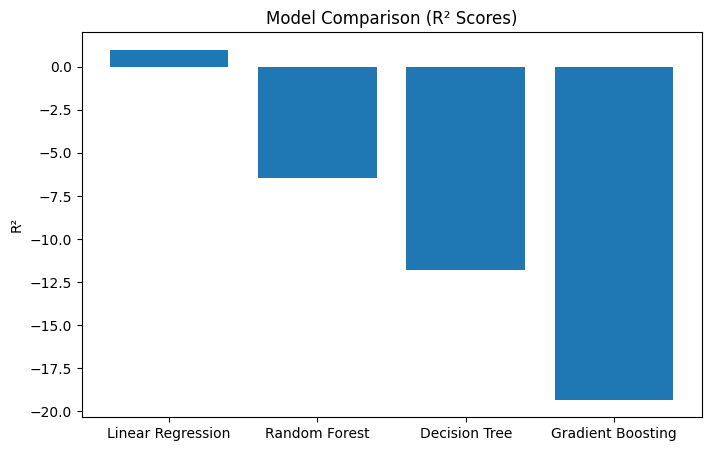

In [70]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Linear Regression'],
    'R²': [r2_score(y_test, y_pred_dt),
           r2_score(y_test, y_pred_rf),
           r2_score(y_test, y_pred_gbr),
           r2_score(y_test, y_pred_lr)],
    'MAE': [mean_absolute_error(y_test, y_pred_dt),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_gbr),
            mean_absolute_error(y_test, y_pred_lr)]
}).sort_values('R²', ascending=False)

print(results)

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['R²'])
plt.title("Model Comparison (R² Scores)")
plt.ylabel("R²")
plt.show()

In [71]:
import pandas as pd
import numpy as np

df = pd.read_excel("check.xlsx")

# Detect key columns automatically
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
year_col = next((c for c in df.columns if 'year' in str(c).lower()), None)
print(f"Detected: {country_col}, {year_col}")

# Required columns mapping (adjust names if needed)
cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    'Urban population': 'urban_pop',
    'Access to improved sanitation (% of total pop.)': 'sanitation'
}

missing = [c for c in cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

df = df.rename(columns=cols)

mort_max = df['under5'].replace(0, np.nan).max() or 1.0
phys_max = df['physicians'].replace(0, np.nan).max() or 1.0

df['E']   = df['primary'] / 100
df['H']   = 1 - (df['under5'] / mort_max)
df['P']   = df['physicians'] / phys_max
df['I']   = df['gni'] / 100
df['Pov'] = 1 - (df['poverty'] / 100)
df['R']   = df['paved_roads'] / 100
df['U']   = df['urban_pop'] / 100
df['S']   = df['sanitation'] / 100


for col in ['E','H','P','I','Pov','R','U','S']:
    df[col] = df[col].clip(0,1)

weights = {'E':0.15,'H':0.15,'P':0.10,'I':0.15,'Pov':0.10,'R':0.10,'U':0.05,'S':0.10}
df['SOL_index'] = sum(df[k]*w for k,w in weights.items())

print(df[[country_col, year_col, 'SOL_index']].head())


Detected: Country code, Year
  Country code  Year  SOL_index
0          ARG  1990   0.766711
1          ARG  1991   0.768411
2          ARG  1992   0.769849
3          ARG  1993   0.770662
4          ARG  1994   0.771606


In [72]:
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')
y = df['SOL_index']


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [74]:
y_class = pd.qcut(y, q=[0, 1/3, 2/3, 1], labels=['Low','Medium','High'])


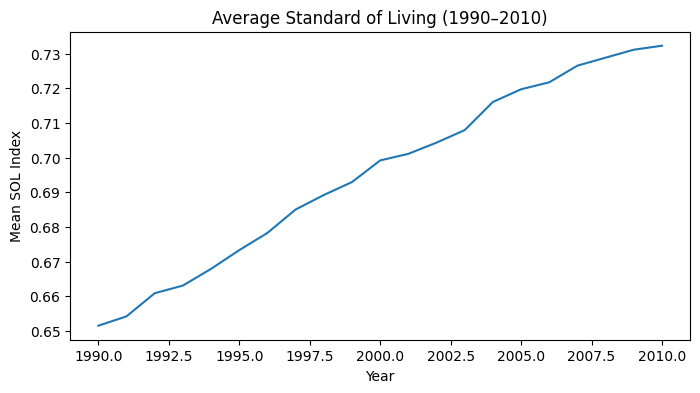

In [75]:
import matplotlib.pyplot as plt
df.groupby(year_col)['SOL_index'].mean().plot(figsize=(8,4))
plt.title("Average Standard of Living (1990–2010)")
plt.xlabel("Year")
plt.ylabel("Mean SOL Index")
plt.show()



=== Gaussian Naive Bayes Classification Report ===
              precision    recall  f1-score   support

         Low       1.00      0.79      0.88        14
      Medium       0.82      1.00      0.90        14
        High       1.00      1.00      1.00        14

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42



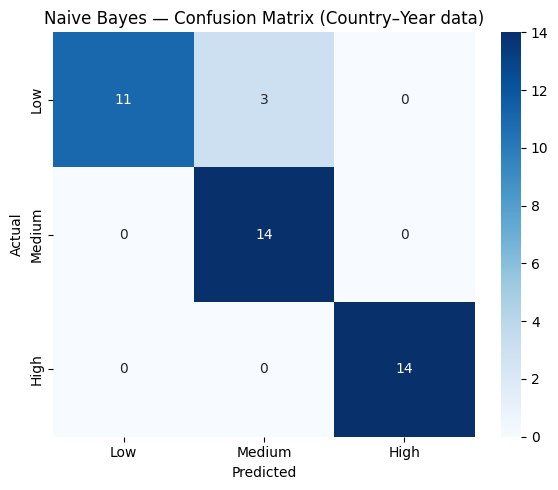

In [76]:
# ============================================================
# 🌍 Classification with Gaussian Naive Bayes (RAW DATA)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# 1️⃣ Features (X) and Target (y)
# -------------------------------
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')
y = df['SOL_index']

# Create Low / Medium / High categories
y_class = pd.qcut(y, q=[0, 1/3, 2/3, 1],
                  labels=['Low', 'Medium', 'High'],
                  duplicates='drop')

# Drop rows with NaN labels
mask = y_class.notna()
X, y_class = X.loc[mask], y_class.loc[mask]
# -------------------------------
# Handle missing values
# -------------------------------
# Fill missing numeric values with column mean (safer than dropping rows)
X = X.fillna(X.mean(numeric_only=True))

# -------------------------------
# 2️⃣ Split + Scale
# -------------------------------
X_train, X_test, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 3️⃣ Train Naive Bayes
# -------------------------------
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_cls)
y_pred = gnb.predict(X_test_scaled)

# -------------------------------
# 4️⃣ Evaluation
# -------------------------------
labels = ['Low', 'Medium', 'High']
print("\n=== Gaussian Naive Bayes Classification Report ===")
print(classification_report(y_test_cls, y_pred, labels=labels, zero_division=0))

cm = confusion_matrix(y_test_cls, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Naive Bayes — Confusion Matrix (Country–Year data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
